In [1]:
import networkx as nx
import numpy as np
from scipy.special import logsumexp
import seaborn as sns
import matplotlib.pyplot as plt

from treesampling.algorithms.castaway_legacy import _castaway_rst_log, _castaway_rst_plain
from treesampling.algorithms import wilson_rst, kirchoff_rst, colbourn_rst, wilson_rst_from_matrix
from treesampling.utils.graphs import graph_weight, tree_to_newick

# from treesample.colbourn import ColbournSample
from treesample.wilson import WilsonSample

In [50]:

matrix = np.array([
    [   0.    , -174.769, -174.769, -244.775, -249.29 , -276.033, -240.241],
    [   0.    ,    0.   ,  -56.238, -124.203, -143.693, -174.44 , -145.639],
    [   0.    ,  -59.999,    0.   ,  -18.449,  -56.7  , -107.202,  -51.118],
    [   0.    , -133.159,    0.   ,    0.   , -126.356, -155.468, -123.161],
    [   0.    , -141.243,  -39.487, -117.625,    0.   , -105.354,  -60.438],
    [   0.    , -177.913,  -78.955, -150.078,  -84.43 ,    0.   , -102.489],
    [   0.    , -131.7  ,  -25.589, -115.073,  -59.796, -109.966,    0.   ]
])
print(logsumexp(matrix, axis=0))
norm_matrix = matrix - logsumexp(matrix, axis=0, keepdims=True)

[1.94591015e+00 0.00000000e+00 6.93147181e-01 9.72077969e-09
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [52]:
sample_size = 10000
tree_counts = {} # nwk_tree: (count, weight)
for i in range(sample_size):
    # tree = _castaway_rst_log(matrix, root=0, trick=False)
    tree = wilson_rst_from_matrix(norm_matrix, root=0, log_probs=True)
    nwk_tree = tree_to_newick(tree)
    tree_w = sum(matrix[u, v] for u, v in tree.edges())
    tree_norm_w = sum(norm_matrix[u, v] for u, v in tree.edges())
    if nwk_tree not in tree_counts:
        print(tree.edges, tree_w, tree_norm_w)
        tree_counts[nwk_tree] = (1, tree_w, tree_norm_w)
    else:
        count, weight, norm_weight = tree_counts[nwk_tree]
        if not np.isclose(weight, tree_w) or not np.isclose(norm_weight, tree_norm_w):
            print(tree.edges)
            print([matrix[u, v] for u, v in tree.edges()])
            print(f"Error: {nwk_tree} has different weights {weight} and {tree_w}")
        tree_counts[nwk_tree] = (count + 1, weight, norm_weight)

KeyboardInterrupt: 

In [23]:
sorted_trees = sorted(tree_counts.items(), key=lambda x: x[1][0], reverse=True)
empirical_freqs = np.array([count for _, (count, _, _) in sorted_trees], dtype=float)
empirical_freqs /= sample_size
expected_freqs = np.array([weight for _, (_, _, weight) in sorted_trees])
expected_freqs = np.exp(expected_freqs - logsumexp(expected_freqs))
print(empirical_freqs), print(np.sum(empirical_freqs))
print(expected_freqs), print(np.sum(expected_freqs))


[3.592e-01 2.873e-01 9.700e-02 8.670e-02 6.830e-02 2.460e-02 2.230e-02
 1.200e-02 1.040e-02 1.000e-02 8.100e-03 5.500e-03 2.500e-03 2.200e-03
 2.200e-03 1.000e-03 5.000e-04 2.000e-04]
1.0
[1.86281443e-02 2.93490056e-03 5.71101376e-35 1.26175472e-01
 8.00849928e-01 4.19885327e-34 7.15256536e-30 1.89913126e-35
 1.85013511e-04 6.96084516e-28 1.32744848e-04 8.42546499e-04
 7.95398907e-03 5.70688633e-03 2.58307782e-36 3.62222501e-02
 8.36811669e-06 3.59757018e-04]
0.9999999999999847


(None, None)

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_82187/4279256024.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 1.0, 'Empirical frequencies of trees')

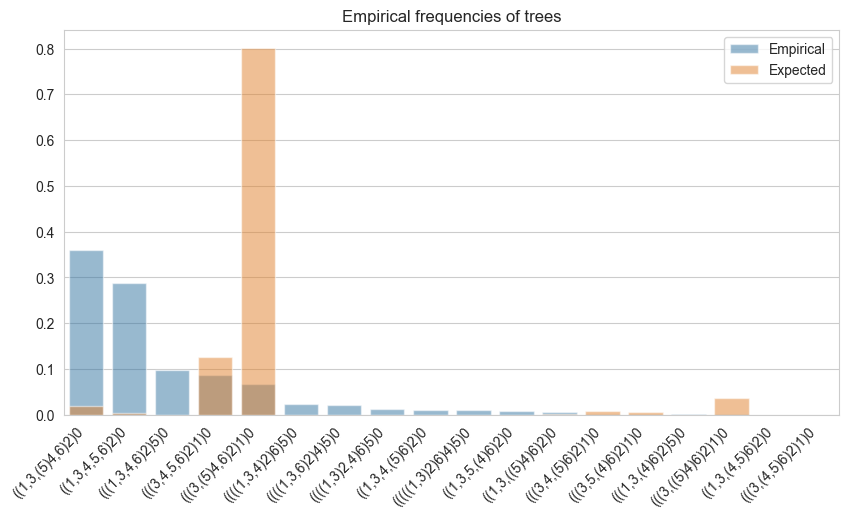

In [24]:
# barplot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=[t for t, _ in sorted_trees], y=empirical_freqs, ax=ax, alpha=0.5, label='Empirical')
sns.barplot(x=[t for t, _ in sorted_trees], y=expected_freqs, ax=ax, alpha=0.5, label='Expected')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Empirical frequencies of trees')


<Axes: >

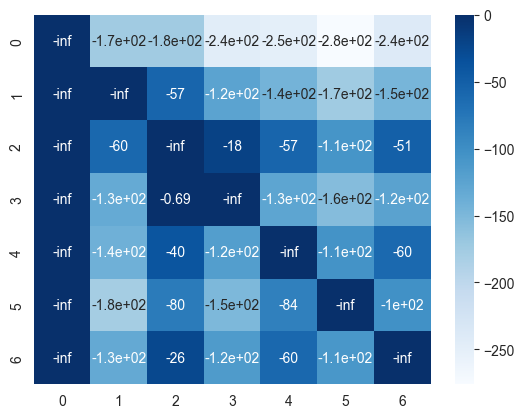

In [6]:
# normalize and try use wilson
norm_matrix = matrix - logsumexp(matrix, axis=0, keepdims=True)
norm_matrix[:, 0] = -np.inf
norm_matrix[np.diag_indices(norm_matrix.shape[0])] = -np.inf
sns.heatmap(matrix, annot=norm_matrix, cmap='Blues')

In [8]:
# colbourn
sample_size = 1000
tree_counts_colbourn = {} # nwk_tree: (count, weight)
for i in range(sample_size):
    graph = nx.from_numpy_array(np.exp(norm_matrix), create_using=nx.DiGraph())
    tree = colbourn_rst(graph, root=0)
    nwk_tree = tree_to_newick(tree)
    tree_w = sum(matrix[u, v] for u, v in tree.edges())
    if nwk_tree not in tree_counts:
        tree_counts_colbourn[nwk_tree] = (1, tree_w)
    else:
        count, weight = tree_counts_colbourn[nwk_tree]
        if not np.isclose(weight, tree_w):
            print(tree.edges)
            print([matrix[u, v] for u, v in tree.edges()])
            print(f"Error: {nwk_tree} has different weights {weight} and {tree_w}")
        tree_counts_colbourn[nwk_tree] = (count + 1, weight)

/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:50: RuntimeWarning: invalid value encountered in divide
  return arr / np.sum(arr, axis=axis, keepdims=True)
/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:190: RuntimeWarning: invalid value encountered in divide
  marginals /= np.sum(marginals)


ValueError: probabilities contain NaN

# Verification
Try to use Wilson on a slightly different matrix

In [9]:
tree1, tree2 = sorted(sorted_trees, key=lambda x: x[1][1], reverse=True)[:2]
tree1, tree2

(('(((3,(5)4,6)2)1)0', (721, -462.628, -463.3211471902846)),
 ('(((3,4,5,6)2)1)0', (929, -464.476, -465.1691471902846)))

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_82187/2478534412.py:11: RuntimeWarning: invalid value encountered in divide
  norm_matrix2 = matrix2 / matrix2.sum(axis=0, keepdims=True)


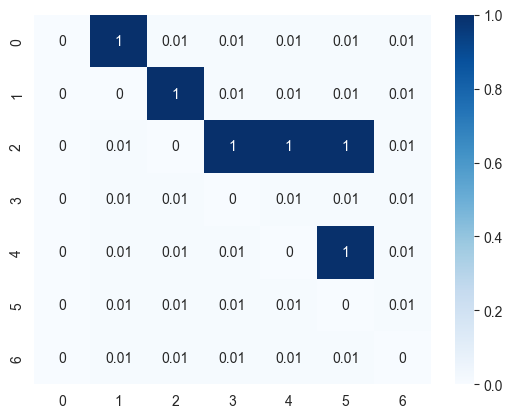

In [15]:
hh = 1. # high weight
ww = 0.01  # weak weight
matrix2 = np.array([[0, hh, ww, ww, ww, ww, ww],
                   [0, 0, hh, ww, ww, ww, ww],
                   [0, ww, 0, hh, hh, hh, ww],
                   [0, ww, ww, 0, ww, ww, ww],
                   [0, ww, ww, ww, 0, hh, ww],
                   [0, ww, ww, ww, ww, 0, ww],
                   [0, ww, ww, ww, ww, ww, 0]])
sns.heatmap(matrix2, annot=True, cmap='Blues')
norm_matrix2 = matrix2 / matrix2.sum(axis=0, keepdims=True)


In [16]:
tree_counts_casta = {} # nwk_tree: (count, weight)
for i in range(10000):
    tree = wilson_rst_from_matrix(norm_matrix2, root=0)
    nwk_tree = tree_to_newick(tree)
    tree_w = np.prod([norm_matrix2[u, v] for u, v in tree.edges()])
    if nwk_tree not in tree_counts_casta:
        tree_counts_casta[nwk_tree] = (1, tree_w)
    else:
        count, weight = tree_counts_casta[nwk_tree]
        if not np.allclose(weight, tree_w):
            print(tree.edges)
            print([matrix2[u, v] for u, v in tree.edges()])
            print(f"Error: {nwk_tree} has different weights {weight} and {tree_w}")
        tree_counts_casta[nwk_tree] = (count + 1, weight)


In [17]:
sorted_trees = sorted(tree_counts_casta.items(), key=lambda x: x[1][0], reverse=True)
empirical_freqs = np.array([count for _, (count, _) in sorted_trees], dtype=float)
empirical_freqs /= sample_size
expected_freqs = np.array([weight for _, (_, weight) in sorted_trees])
expected_freqs = np.exp(expected_freqs - logsumexp(expected_freqs))
print(empirical_freqs), print(np.sum(empirical_freqs))
print(expected_freqs), print(np.sum(expected_freqs))


[0.771 0.763 0.762 0.759 0.751 0.728 0.725 0.721 0.717 0.705 0.704 0.694
 0.014 0.014 0.014 0.014 0.013 0.012 0.012 0.012 0.012 0.012 0.012 0.012
 0.012 0.012 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011
 0.011 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.009 0.009 0.009 0.009 0.009 0.009 0.009
 0.009 0.009 0.009 0.009 0.009 0.009 0.008 0.008 0.008 0.008 0.008 0.008
 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.008 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007
 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.006 0.006 0.006
 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.004
 0.003 0.003 0.003 0.003 0.003 0.002 0.002 0.001 0.0

(None, None)

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_82187/2420078642.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 1.0, 'Empirical frequencies of trees')

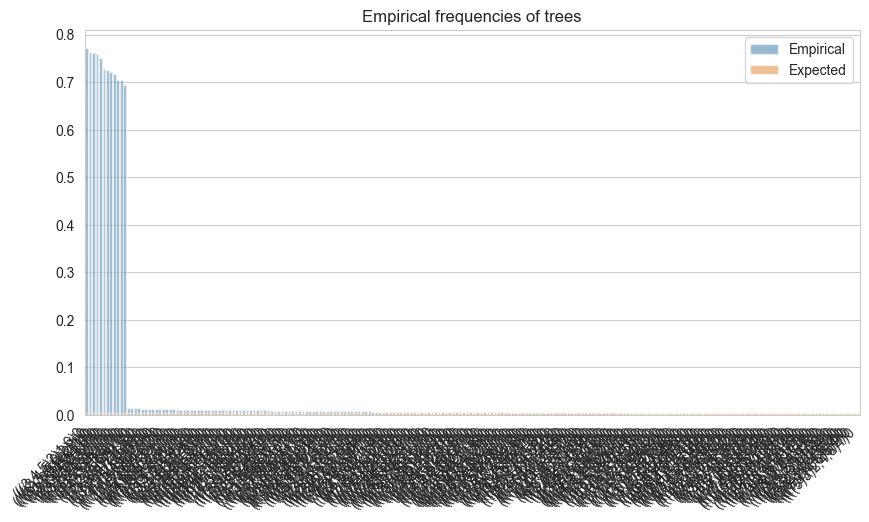

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=[t for t, _ in sorted_trees], y=empirical_freqs, ax=ax, alpha=0.5, label='Empirical')
sns.barplot(x=[t for t, _ in sorted_trees], y=expected_freqs, ax=ax, alpha=0.5, label='Expected')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Empirical frequencies of trees')


# Uniform matrix small instance


In [32]:

def laplacian(A, r):
    """
    Root-weighted Laplacian of Koo et al. (2007)
    A is the adjacency matrix and r is the root weight
    """
    L = -A + np.diag(np.sum(A, 0))
    L[0] = r
    return L


In [48]:
from treesampling.utils.graphs import tuttes_tot_weight

K = 4
N = 1000000
# random matrix
W = np.random.uniform(0, 1, size=(K, K))
np.fill_diagonal(W, 0)
# prepare normalization factor
A = np.copy(W)
L = laplacian(A[1:, 1:], A[0, 1:])
new_det = np.linalg.det(L)
graph = nx.from_numpy_array(W, create_using=nx.DiGraph)
tuttes_det = tuttes_tot_weight(graph, root=0)
print(f"tuttes det: {tuttes_det}")
Z = tuttes_det
print(f"chosen tot weight Z: {Z}")

W = np.log(W)

# gather sample
dist = {}
real_prob = {}
for _ in range(N):
    # tree = _castaway_rst_log(W, 0, trick=False)
    tree = wilson_rst_from_matrix(W, root=0, log_probs=True)
    tree_nwk = tree_to_newick(tree)
    if tree_nwk not in dist:
        real_prob[tree_nwk] = np.exp(sum([W[u, v] for u, v in tree.edges()])) / Z
        dist[tree_nwk] = 0
    dist[tree_nwk] += 1 / N



tuttes det: 0.6131865768599338
chosen tot weight Z: 0.6131865768599338


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_82187/2108313738.py:18: RuntimeWarning: divide by zero encountered in log
  W = np.log(W)


/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_82187/1298509493.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 1.0, 'Empirical frequencies of trees (N=1000000)')

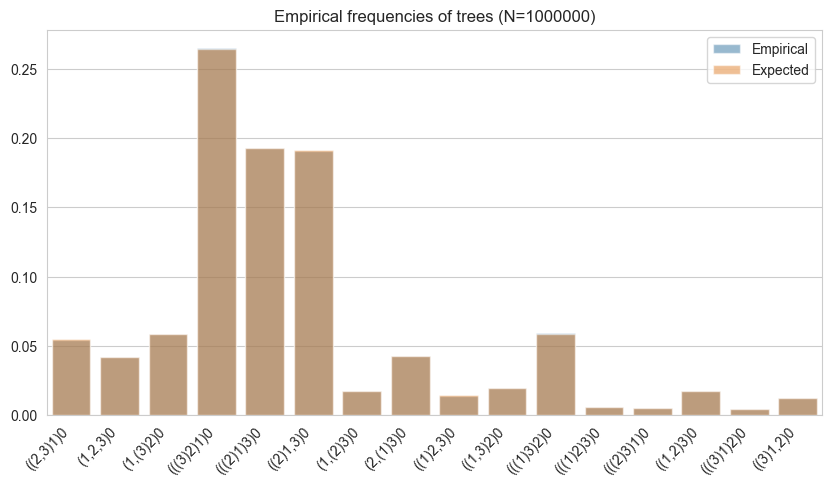

In [49]:
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=list(dist.keys()), y=list(dist.values()), ax=ax, alpha=0.5, label='Empirical')
sns.barplot(x=list(real_prob.keys()), y=list(real_prob.values()), ax=ax, alpha=0.5, label='Expected')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title(f'Empirical frequencies of trees (N={N})')
